# Project 2

<bk>
    Dieter Brehm and Corinne Wilklow

In [267]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [268]:
# load r_values of common insulation into a dataframe
R_data = pd.read_csv('R_values1.csv', header=0, index_col=0, usecols=range(1,2))

""
R
1.25
3.71
3.85
4.00
4.13
4.29
5.00
5.00
6.50


In [269]:
# Load dataset values
ext_data = pd.read_csv('DataOWall.csv', parse_dates=[0], index_col=0, header=0, skiprows=[1,2])
ext_data.head()

,Q_in,Q_out,T_int,T_ext
2014-10-05 16:30:00,10.994,6.840,16.92,14.68
2014-10-05 16:35:00,10.952,6.012,16.92,14.69
2014-10-05 16:40:00,10.882,7.040,16.93,14.66
2014-10-05 16:45:00,10.798,8.880,16.93,14.59
2014-10-05 16:50:00,10.756,10.491,16.94,14.50


In [270]:
# Convert Index entries to seconds, noticing the spacing between recordings
timestamp_0 = get_first_label(ext_data)
time_deltas = ext_data.index - timestamp_0;

ext_data.index = time_deltas.days * 86400 + time_deltas.seconds

In [271]:
# convert index entries to hours
ext_data.T_ext.head()
T_ext_external = ext_data.T_ext
for i, v in ext_data.T_ext.items():
    scaled = i / 3600
    T_ext_external = T_ext_external.rename(index={i: scaled})
    
T_ext_external.head()

0.000000    14.68
0.083333    14.69
0.166667    14.66
0.250000    14.59
0.333333    14.50
Name: T_ext, dtype: float64

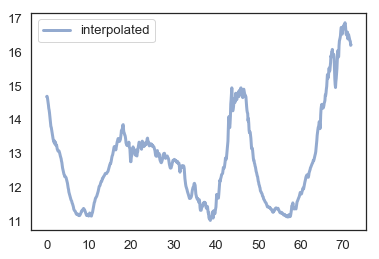

In [272]:
# plot the exterior temp data on top of the interpolation of the data
t_ext_func = interpolate(T_ext_external)
plot(T_ext_external.index, t_ext_func(T_ext_external.index), label="interpolated")
legend()

In [273]:
def make_system(params):
    """Make a system object for insulation model.
    
    params object should contain:
    T_ext: the starting exterior temperature
    T_int: the starting interior tempature
    R: the R-rating of the insulation, in units ft^2*deg5/btu/hr/in
    d: the depth of the insulation, in units Inches
    l: house length in meters
    w: house width in meters
    h: house height in meters
    c: c value of air for Newton's law of cooling, in units btu/lbm*R
    
    returns: System object
    """
    T_int, T_ext, R, d, l, w, h, c = params
                
    # density of air
    rho = 1

    # m/s^2, acceleration due to gravity
    g = 9.8 
    
    # air volume inside house m^3
    V = l * w * h

    # mass of air in room in lb
    m = (rho * V * g) * 2.2 
                
    # calculate surface area, and convert from m^2 to ft^2
    SA = (l * w * 4 + h * l * 2) * 10.7639

    first = State(T_int=T_int, T_ext=T_ext)
    
    # time constants
    t0 = 0
    t_end = 80
    dt = .5

    return System(init=first, t0=t0, t_end=t_end, dt=dt, R=R, d=d, SA=SA, m=m, c=c)

In [274]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end,system.dt):
        frame.row[t+system.dt] = update_func(frame.row[t], t, system)
    
    return frame

In [280]:
def update_func(state, t, system):
    """Update the model.
    
    state: State with variables T_int, T_ext
    dt: time step
    system: System
    
    returns: State object
    """
    
    T_int, T_ext = state
    
    #test this by overwritting state value
    T_ext = t_ext_func(t) * 9 / 5 + 32
    
    delta_T = T_int - T_ext
    
    dQ = (system.SA * delta_T / (system.R * system.d)) * system.dt
   
    if system.c == 0:
        system.c = dQ / delta_T
    
    
    dT = dQ / (system.c * system.m) 
    
    T_int = T_int - dT
    
    #print(dT)
    
    return State(T_int = T_int, T_ext = T_ext)

In [281]:
# set our system parameters and generate a system object
params = Params(T_int = 60,
                T_ext = get_first_value(ext_data.T_ext)*9/5+32,
                R = 3,
                d = 4,
                l = 6,
                w = 6,
                h = 6,
                c = 0.171)
print(params[2])
                
system = make_system(params)

3.0


,values
init,T_int 60.000 T_ext 58.424 dtype: float64
t0,0
t_end,80
dt,0.5
R,3
d,4
SA,2325
m,4656.96
c,0.171


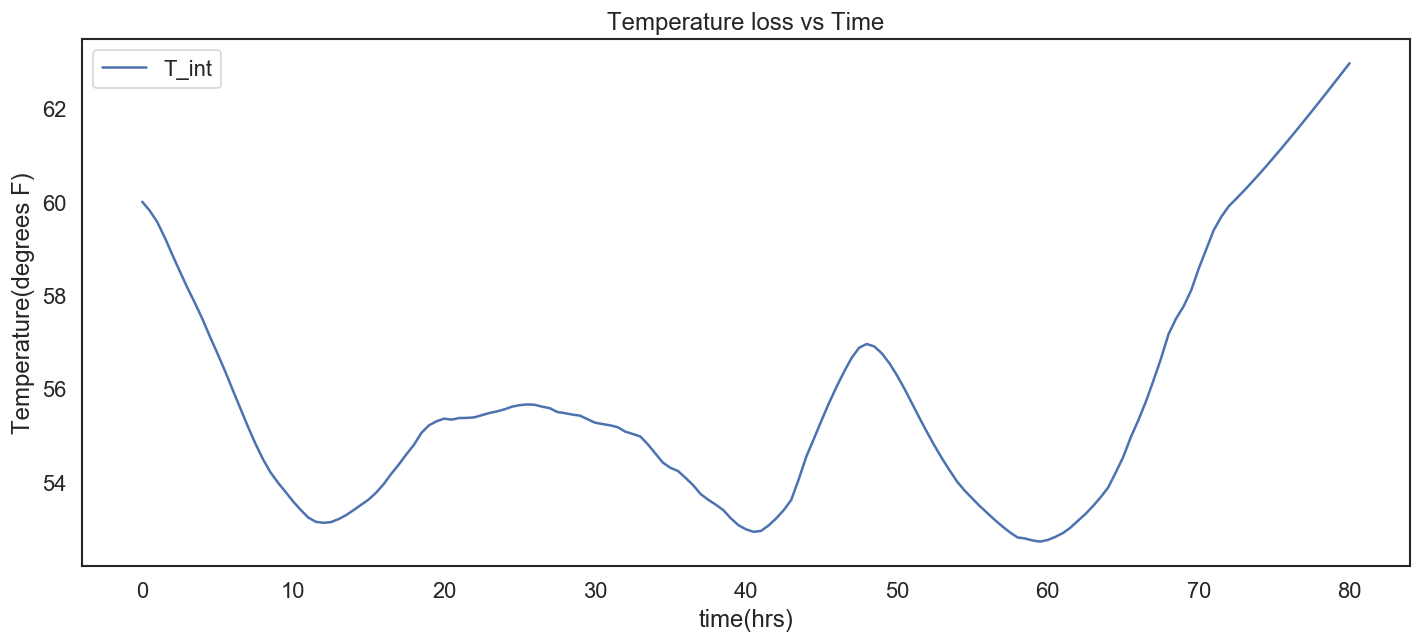

In [282]:
#test the simulation with the r value set in params
results = run_simulation(system, update_func)


fig1 = plt.figure(figsize=(12, 10), dpi=120,)
ax1 = fig1.add_subplot(211)    
ax1.plot(results.T_int)
decorate(title = 'Temperature loss vs Time',
         xlabel = 'time(hrs)',
         ylabel = 'Temperature(degrees F)')

In [309]:
def sweep_R(R_data):
    """
    Sweep a range of values of R and plot them
    R_data: list of r values
    """
    
    # names of the commercially available insulations, index of this list matches that or r-val csv
    insulation = ['plywood','EcoTouch','R-tech','Kingspan','Comfortbatt gold','Comfortbatt blue',
                                      'Foamular','SilveRboard','Super TUFF','polyisocyanurate (foil-faced)']
    
    fig1 = plt.figure(figsize=(18, 16), dpi=120)
    ax1 = fig1.add_subplot(211)
    
    for R in R_data.index.values:
        # change our R to the one in this loop of the sweep
        params[2] = R
        
        systemr = make_system(params)
        results = run_simulation(systemr, update_func)
        location = np.where(R_data.index == R)
        location = location[0].tolist()
        ax1.plot(results.T_int, label=str(R) + ' ' + insulation[location[0]])
 
    
    ax1.plot(results.T_int.index, t_ext_func(results.T_int.index)  * 9 / 5 + 32, label="interpolated exterior data")
    
    ax1.plot([0, 80], [55, 55], color='k', linestyle='-', linewidth=2, label="minimum acceptable temperature")
    
    decorate(title = 'Temperature loss vs Time',
            xlabel = 'time(hrs)',
            ylabel = 'Temperature(degrees F)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

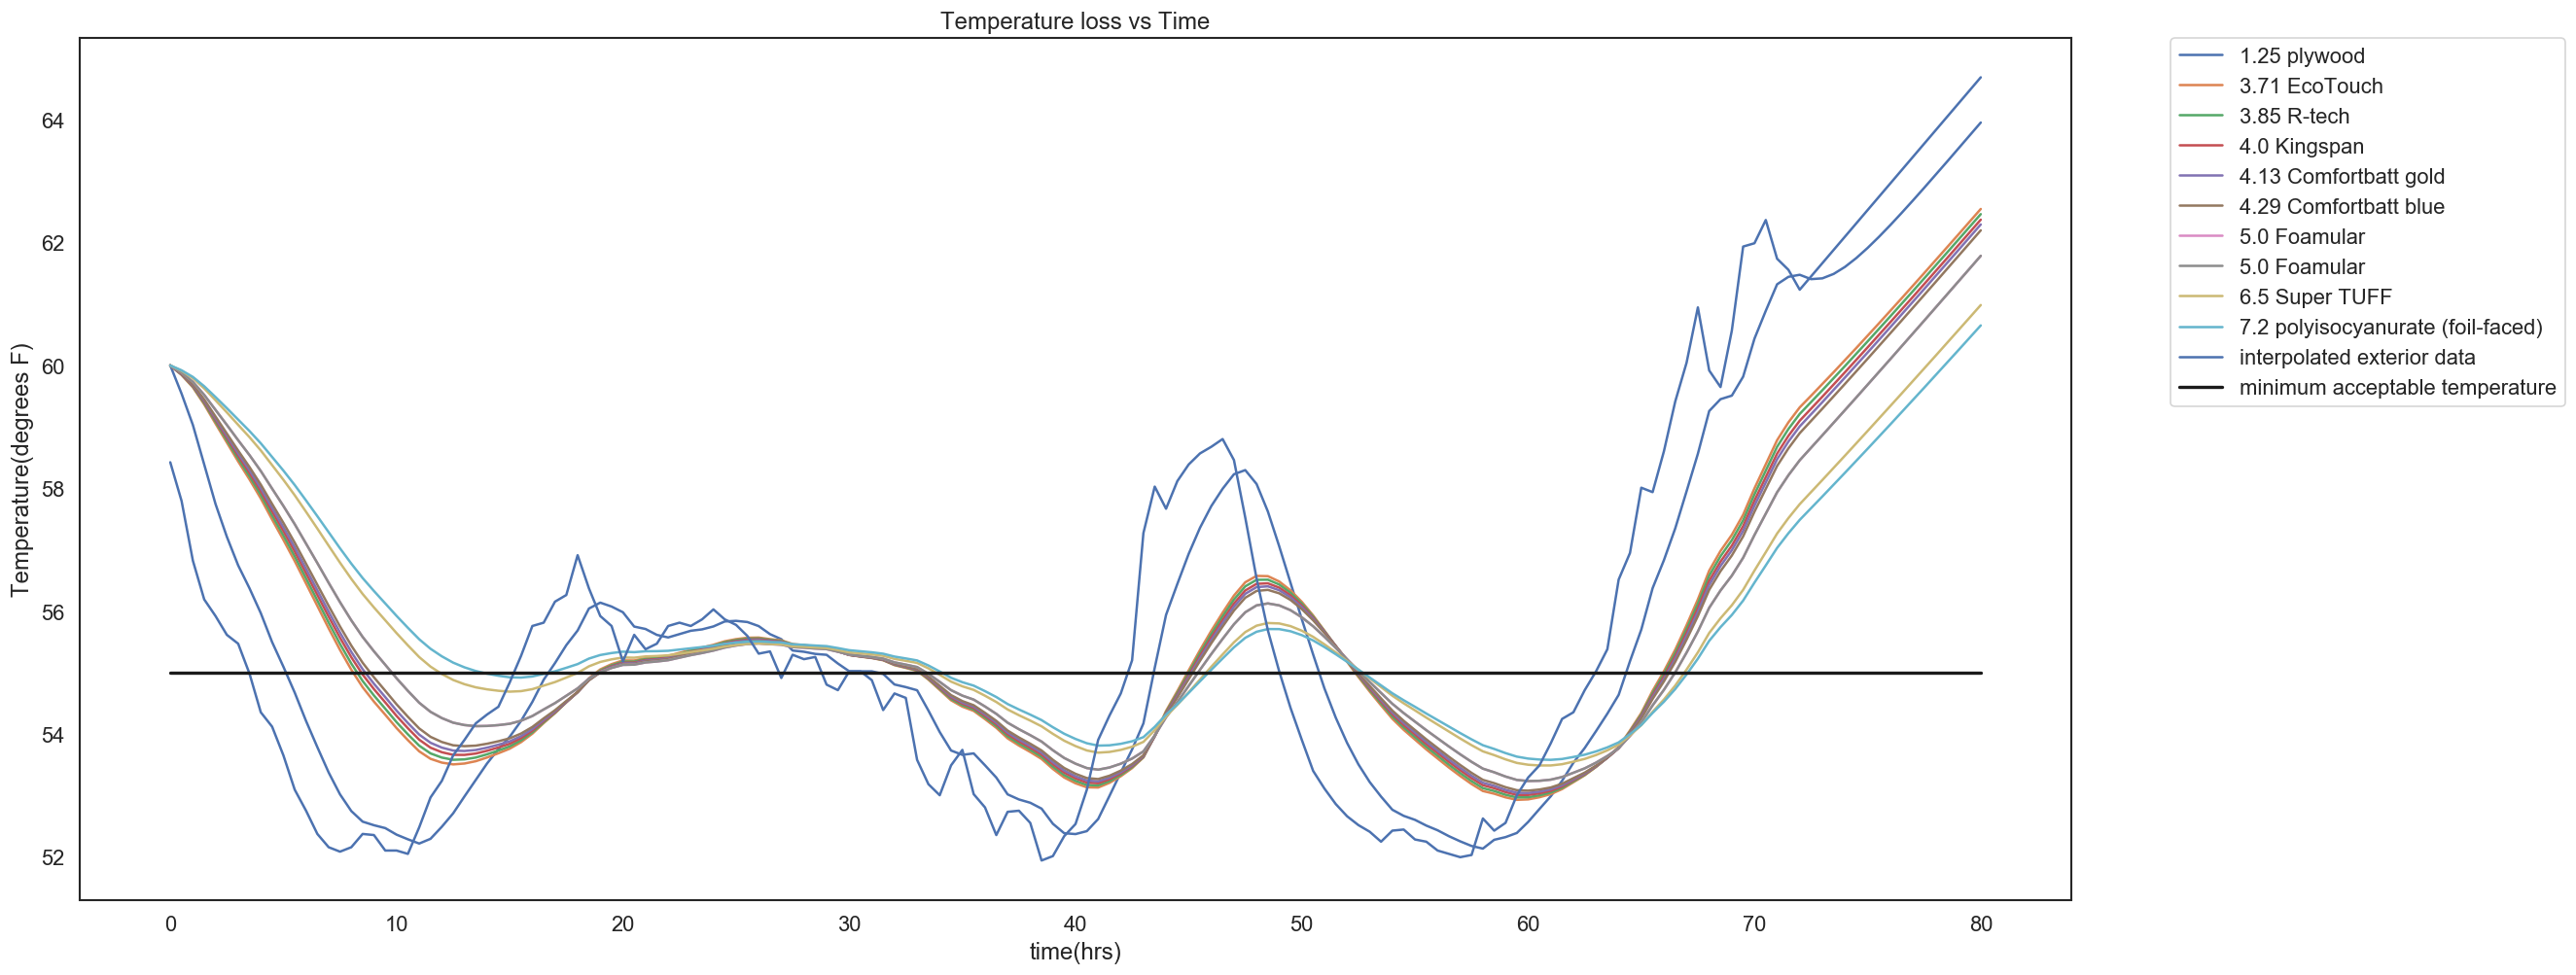

In [310]:
sweep_R(R_data)